In [23]:
import pandas as pd

## Produce Graph for Single Alpha

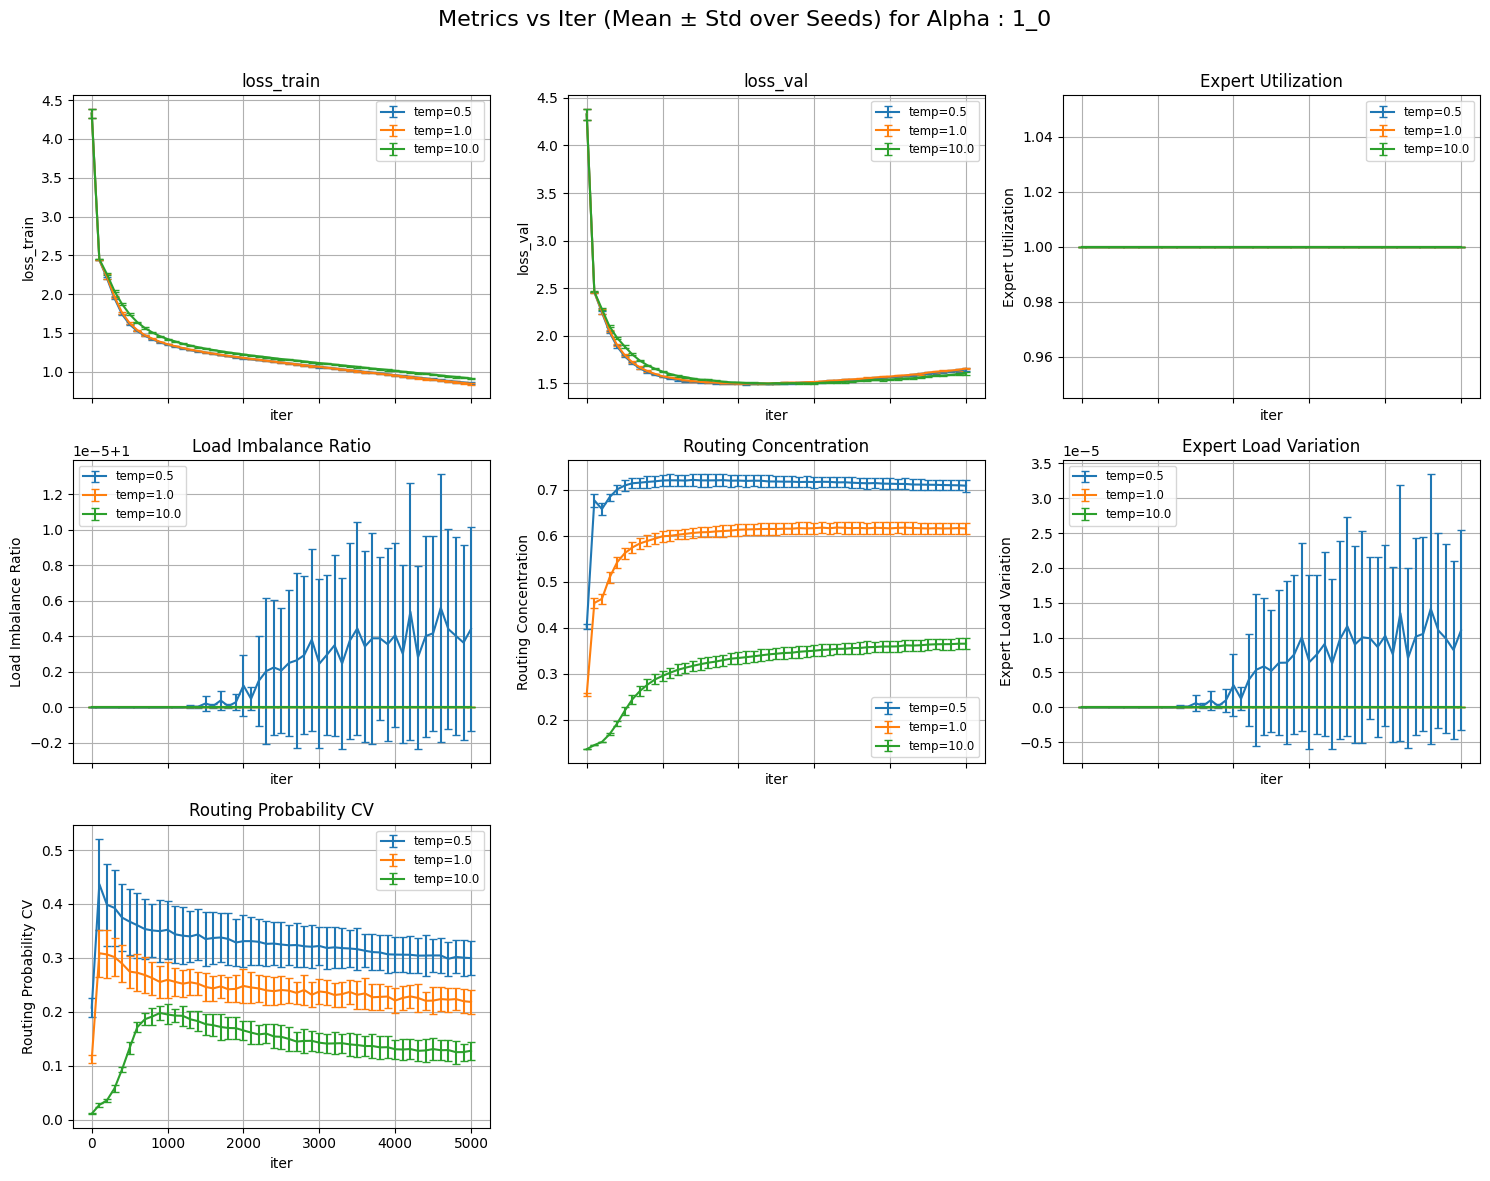

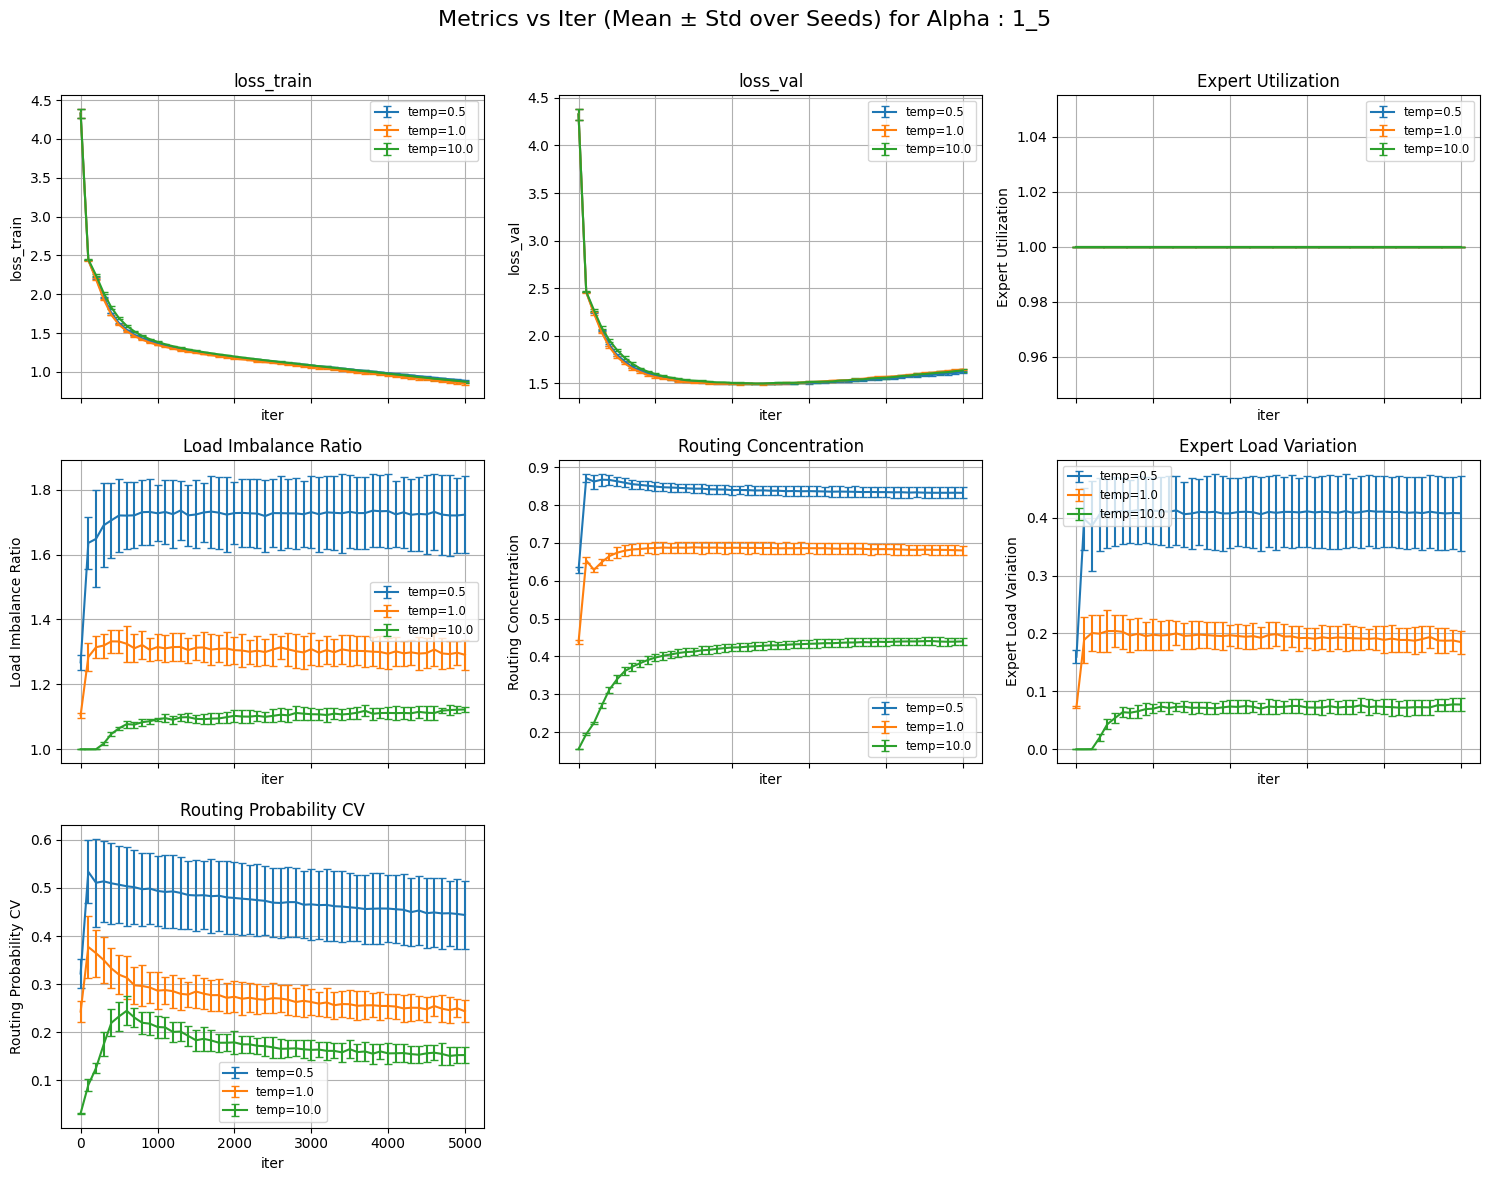

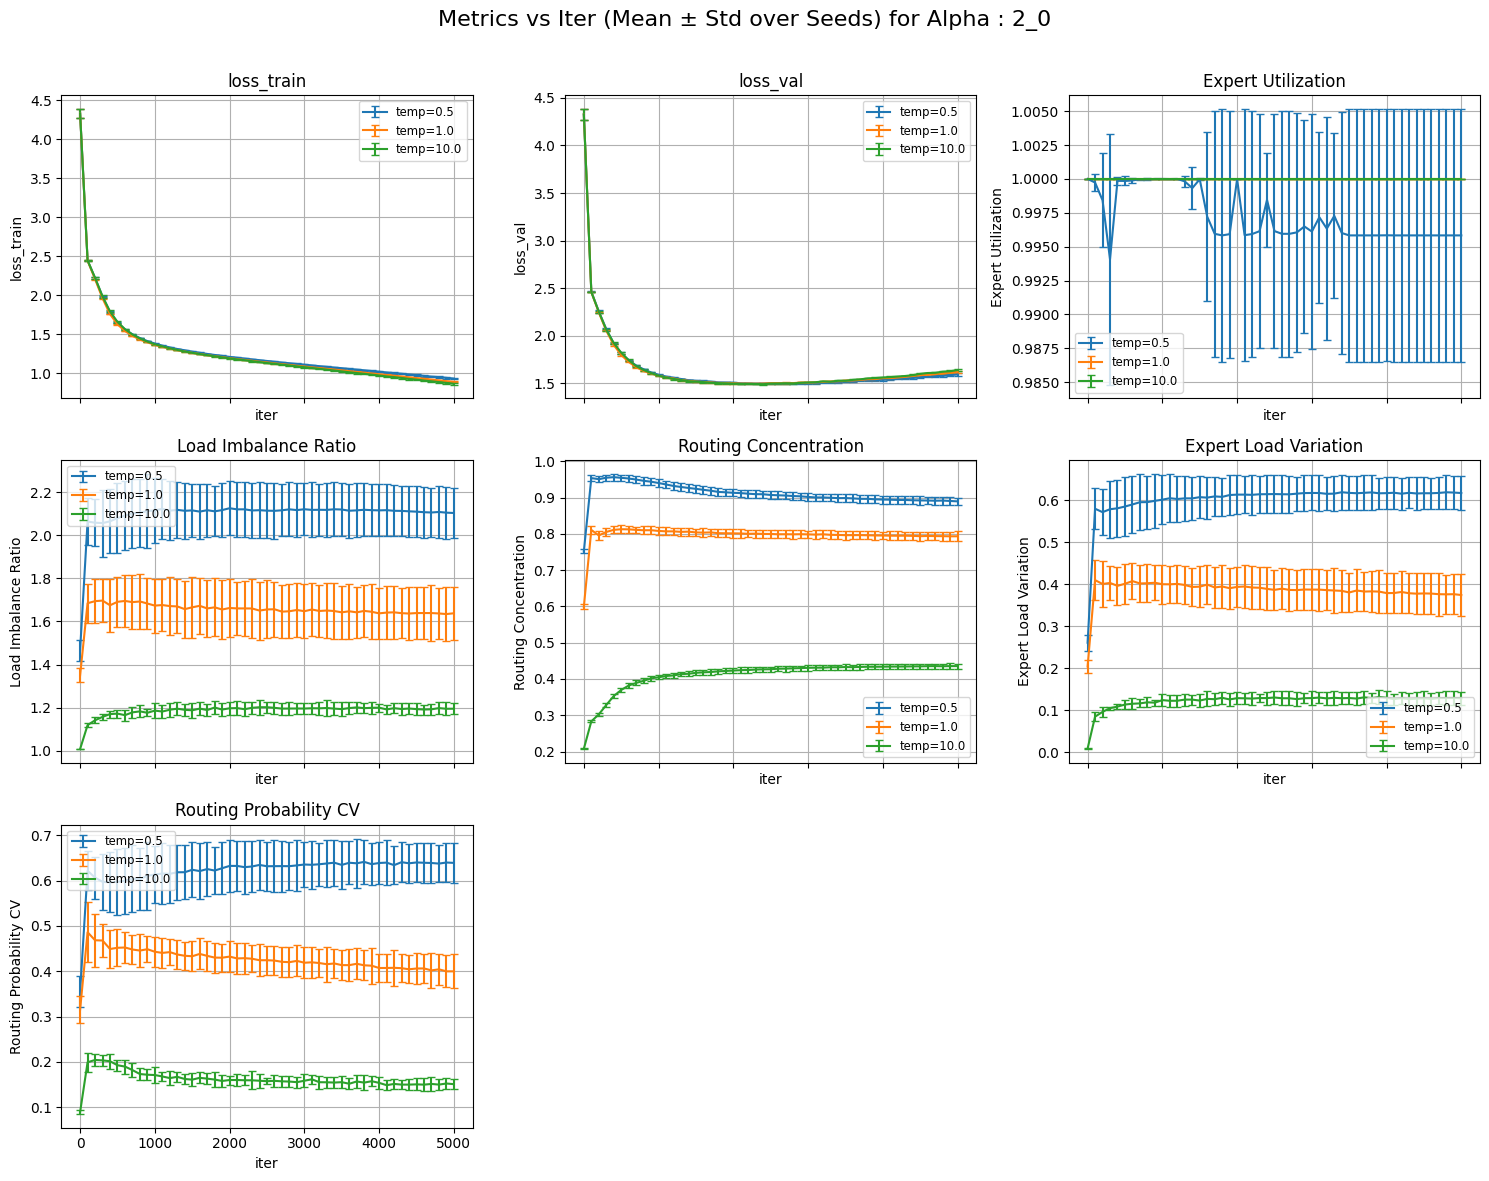

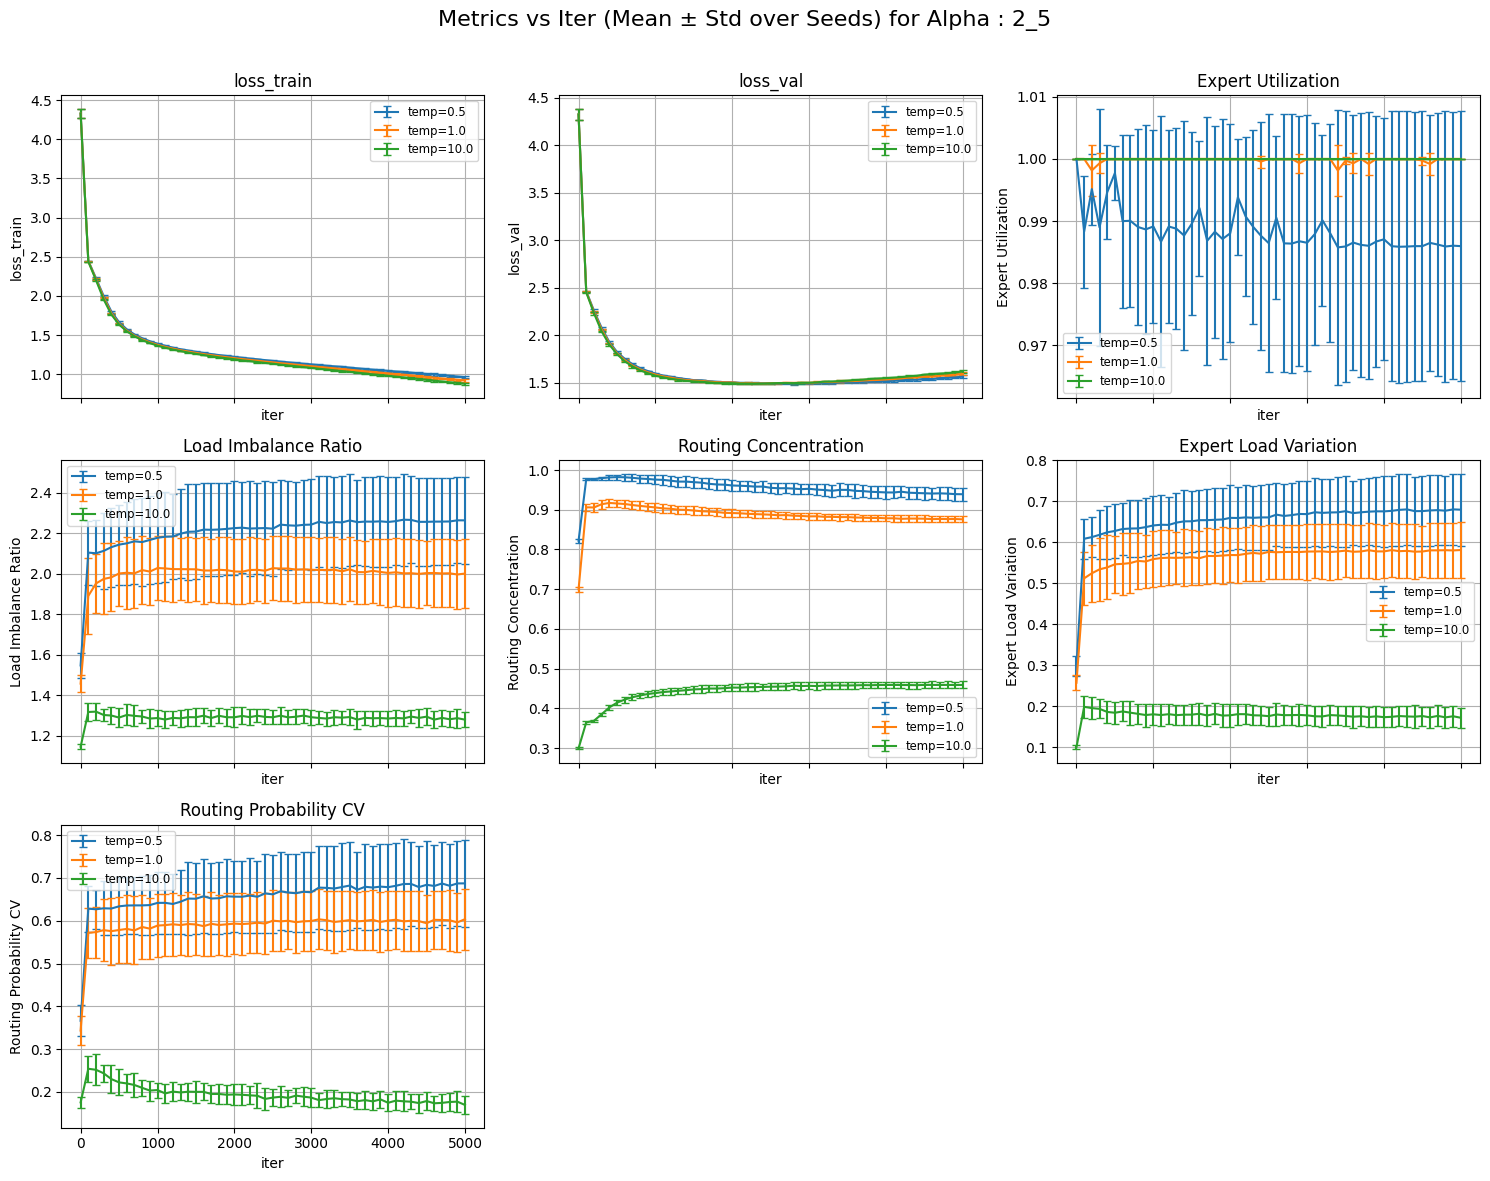

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

alphas = ['1_0', '1_5', '2_0' , '2_5']
for alpha in alphas:
    # Load data
    df = pd.read_csv(f'./results_csv/alpha_{alpha}.csv')
    
    # Metrics to plot
    metric_cols = ['loss_train', 'loss_val', 'Expert Utilization', 'Load Imbalance Ratio',
                   'Routing Concentration', 'Expert Load Variation', 'Routing Probability CV']
    
    # Group by temperature and iter
    mean_df = df.groupby(['temperature', 'iter'])[metric_cols].mean().reset_index()
    std_df = df.groupby(['temperature', 'iter'])[metric_cols].std().reset_index()
    
    # Grid setup
    n_cols = 3
    n_rows = -(-len(metric_cols) // n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()
    
    # Plot with error bars
    for idx, metric in enumerate(metric_cols):
        ax = axes[idx]
        for temp in sorted(df['temperature'].unique()):
            mean_temp_df = mean_df[mean_df['temperature'] == temp].sort_values('iter')
            std_temp_df = std_df[std_df['temperature'] == temp].sort_values('iter')
    
            ax.errorbar(mean_temp_df['iter'], mean_temp_df[metric],
                        yerr=std_temp_df[metric],
                        label=f'temp={temp}', capsize=3)
    
        ax.set_title(metric)
        ax.set_xlabel("iter")
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend(fontsize='small')
    
    # Hide unused subplots
    for j in range(len(metric_cols), len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(f"Metrics vs Iter (Mean ± Std over Seeds) for Alpha : {alpha}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f'./output/alpha_{alpha}.png', dpi=300)
    plt.show()


# Compare Across Alpha

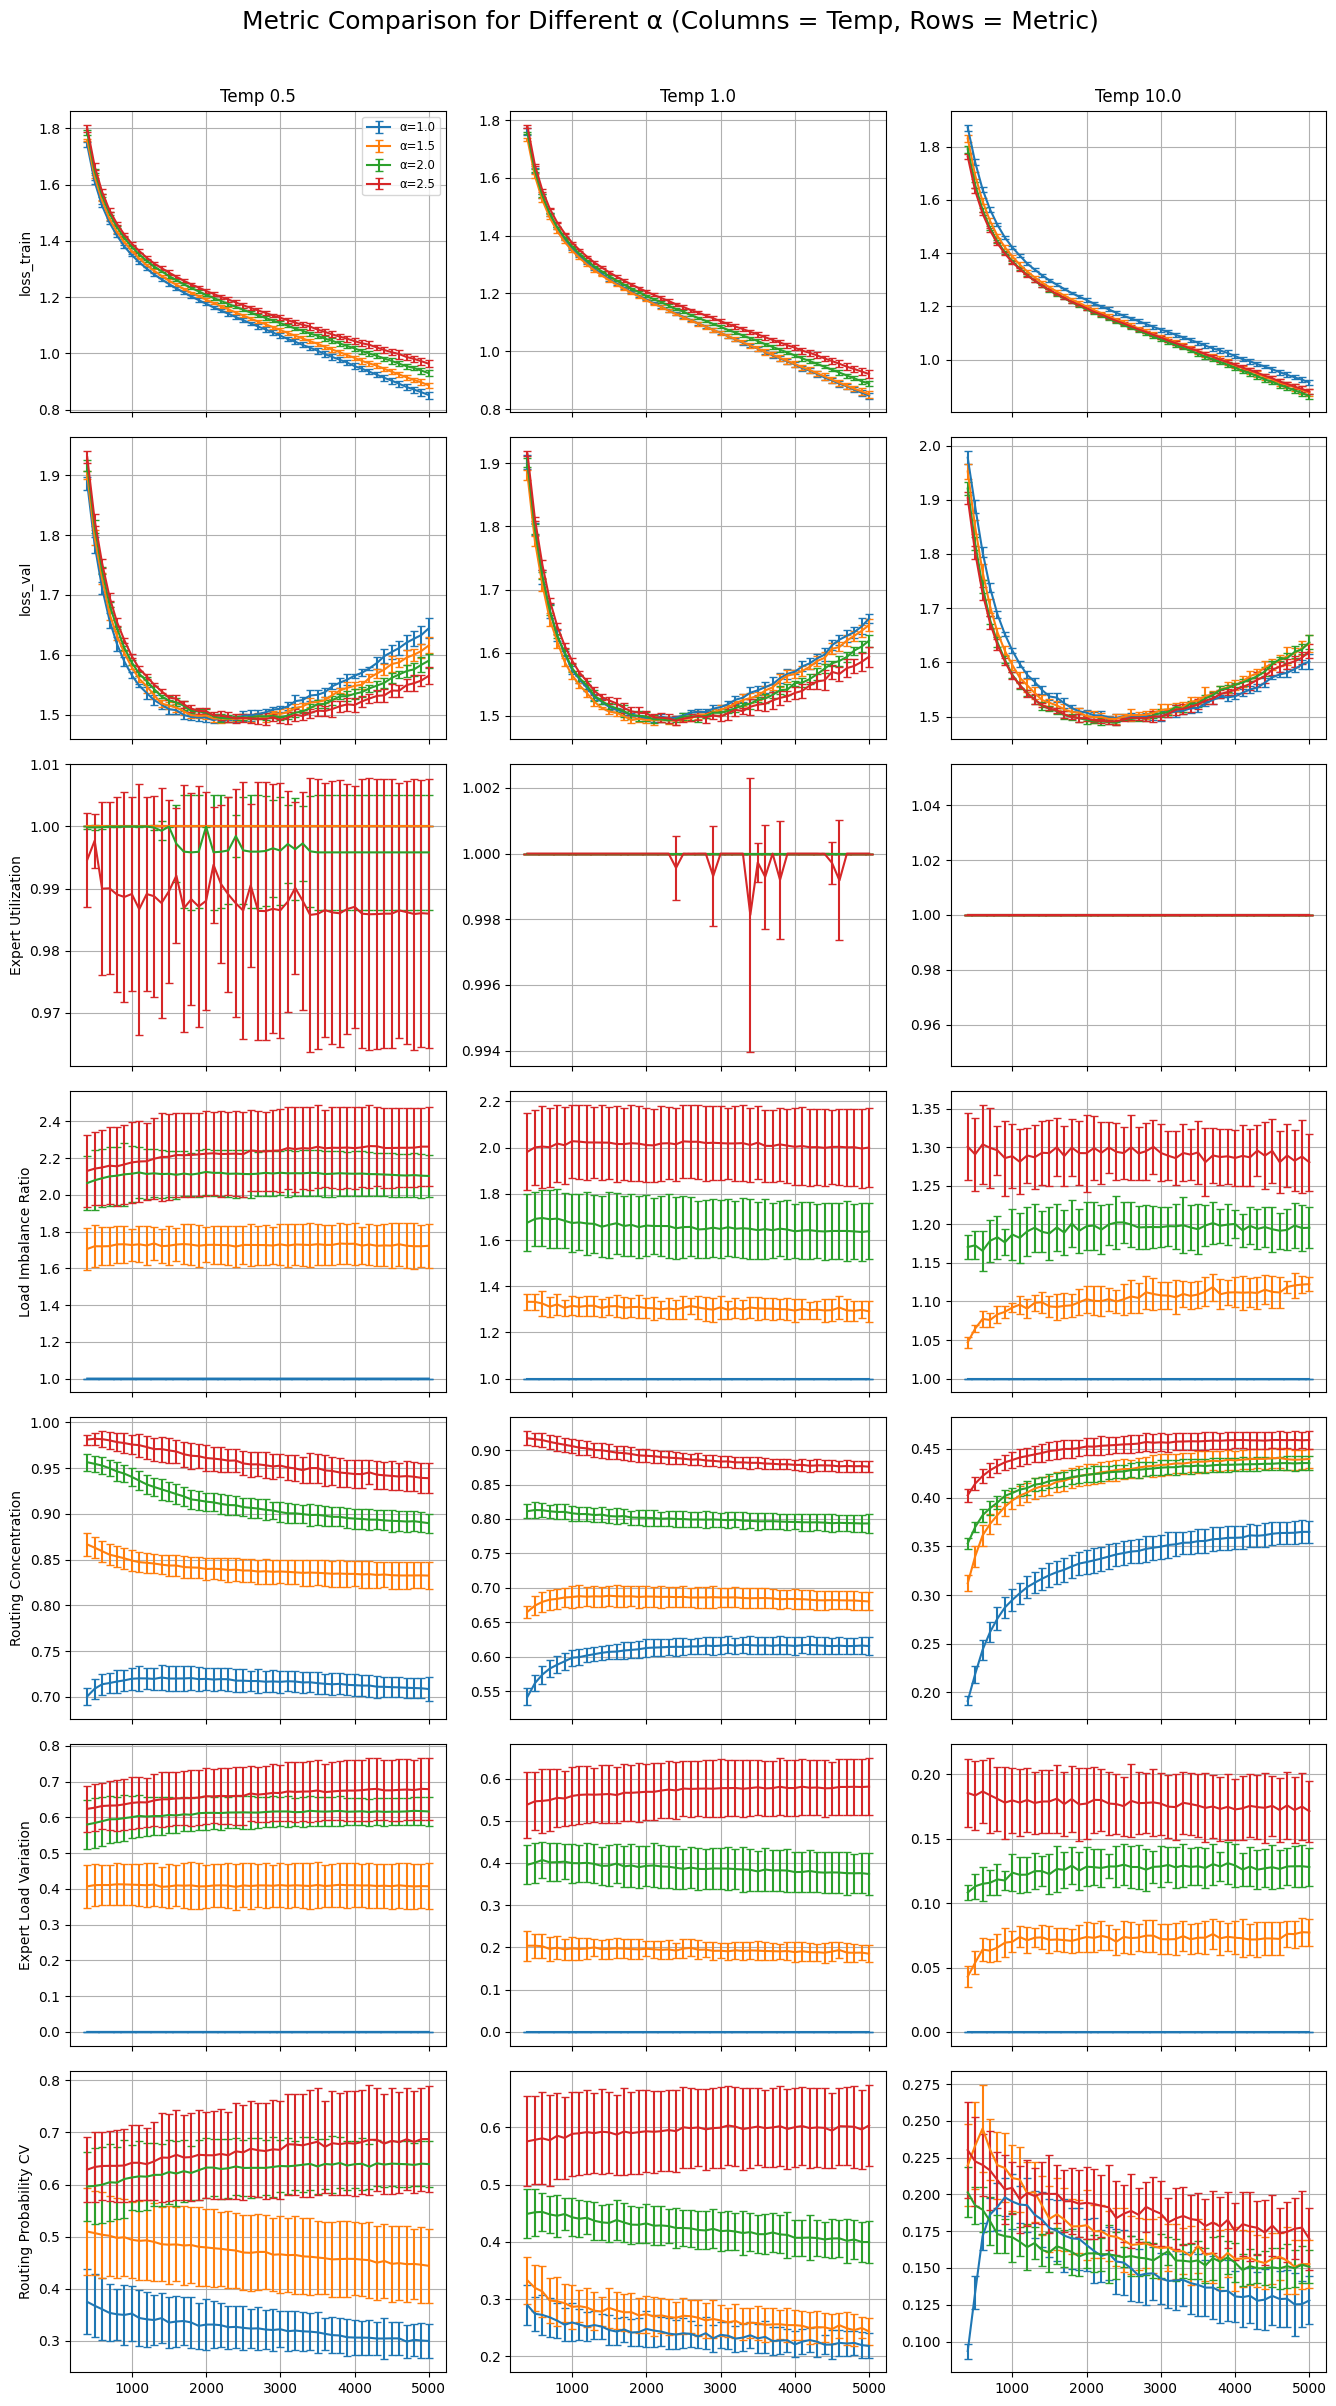

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
df1 = pd.read_csv("results_csv/alpha_1_0.csv")
df2 = pd.read_csv("results_csv/alpha_1_5.csv")
df3 = pd.read_csv("results_csv/alpha_2_0.csv")
df4 = pd.read_csv("results_csv/alpha_2_5.csv")


# Combine all into one DataFrame
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

df = df[df['iter'] > 300]

# Define metrics and unique temperatures
metric_cols = ['loss_train', 'loss_val', 'Expert Utilization', 'Load Imbalance Ratio',
               'Routing Concentration', 'Expert Load Variation', 'Routing Probability CV']
temps = sorted(df['temperature'].unique())

# Compute mean and std across seeds
group_mean = df.groupby(['temperature', 'alpha', 'iter'])[metric_cols].mean().reset_index()
group_std = df.groupby(['temperature', 'alpha', 'iter'])[metric_cols].std().reset_index()

# New layout: rows = metrics, cols = temperatures
n_rows = len(metric_cols)
n_cols = len(temps)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows), sharex='col')
axes = axes.reshape(n_rows, n_cols)

# Plot
for i, metric in enumerate(metric_cols):
    for j, temp in enumerate(temps):
        ax = axes[i, j]
        for alpha in sorted(df['alpha'].unique()):
            mean_sub = group_mean[(group_mean['temperature'] == temp) & (group_mean['alpha'] == alpha)].sort_values('iter')
            std_sub = group_std[(group_std['temperature'] == temp) & (group_std['alpha'] == alpha)].sort_values('iter')

            ax.errorbar(mean_sub['iter'], mean_sub[metric], yerr=std_sub[metric],
                        label=f'α={alpha}', capsize=3)

        if i == 0:
            ax.set_title(f"Temp {temp}")
        if j == 0:
            ax.set_ylabel(metric)
        ax.grid(True)
        if i == 0 and j == 0:
            ax.legend(fontsize='small')

fig.suptitle("Metric Comparison for Different α (Columns = Temp, Rows = Metric)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('./output/all_compared.png', dpi=300)
plt.show()


# Bar plot of last iteration Validation loss

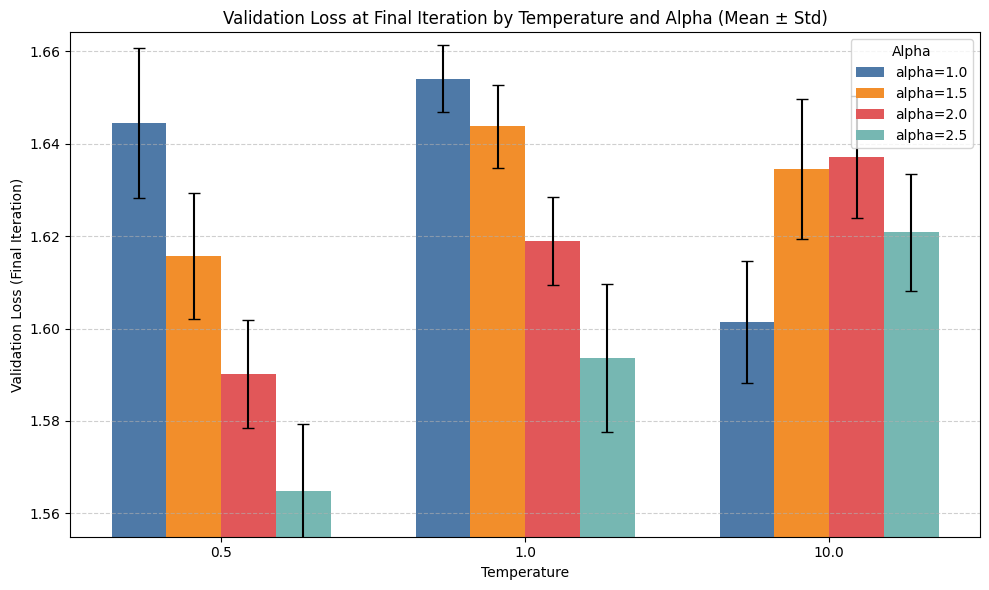

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Modern color palette
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']

# File mapping for each alpha
alpha_files = {
    '1.0': './results_csv/alpha_1_0.csv',
    '1.5': './results_csv/alpha_1_5.csv',
    '2.0': './results_csv/alpha_2_0.csv',
    '2.5': './results_csv/alpha_2_5.csv'

}

results = []

for alpha, file_path in alpha_files.items():
    df = pd.read_csv(file_path)

    # Find the last iteration value for each (temperature, seed)
    last_iter = df['iter'].max()
    last_df = df[df['iter'] == last_iter]

    # Compute mean and std of loss_val at last iteration per temperature
    summary = last_df.groupby(['temperature'])['loss_val'].agg(['mean', 'std']).reset_index()
    summary['alpha'] = alpha

    results.append(summary)

# Combine all summaries
all_data = pd.concat(results)

# Convert to categorical for plotting
all_data['temperature'] = all_data['temperature'].astype(str)
all_data['alpha'] = all_data['alpha'].astype(str)

# Pivot for grouped bar plot
pivot_mean = all_data.pivot(index='temperature', columns='alpha', values='mean')
pivot_std = all_data.pivot(index='temperature', columns='alpha', values='std')

# Sort temperatures and alphas
temperatures = sorted(pivot_mean.index.tolist(), key=float)
alphas = sorted(pivot_mean.columns.tolist(), key=float)

# Plot settings
x = np.arange(len(temperatures))
width = 0.18

plt.figure(figsize=(10, 6))

# Plot each alpha's bar at final iter
for i, alpha in enumerate(alphas):
    means = pivot_mean.loc[temperatures, alpha]
    stds = pivot_std.loc[temperatures, alpha]
    plt.bar(x + i * width, means, width, yerr=stds, capsize=4, label=f'alpha={alpha}',
            color=colors[i % len(colors)])

# X-axis labels
plt.xticks(x + width * (len(alphas) - 1) / 2, temperatures)
plt.xlabel('Temperature')
plt.ylabel('Validation Loss (Final Iteration)')
plt.title('Validation Loss at Final Iteration by Temperature and Alpha (Mean ± Std)')
plt.legend(title='Alpha')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Zoom y-axis to highlight differences
min_val = all_data['mean'].min()
max_val = all_data['mean'].max()
plt.ylim(bottom=min_val - 0.01, top=max_val + 0.01)

plt.tight_layout()
plt.savefig("./output/last_iter_val_loss_bar.png", dpi=600)
plt.show()


# Bar plot of Best iteration Val Loss

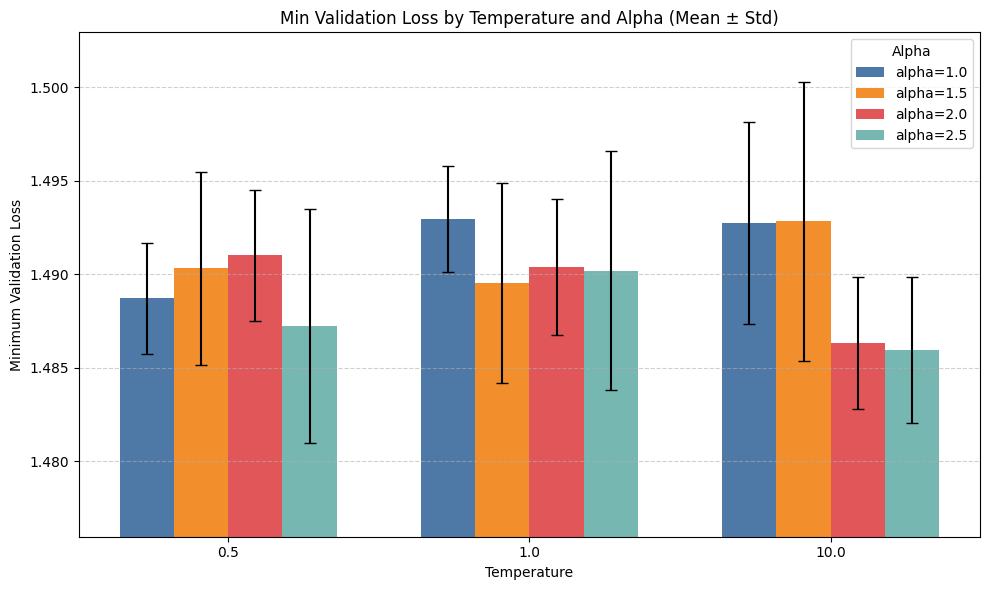

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File mapping for each alpha
alpha_files = {
    '1.0': './results_csv/alpha_1_0.csv',
    '1.5': './results_csv/alpha_1_5.csv',
    '2.0': './results_csv/alpha_2_0.csv',
    '2.5': './results_csv/alpha_2_5.csv'
}

# Use a modern color palette (Tableau 10 or Seaborn's deep)
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']  # Modern & colorblind-friendly


results = []

# Process each CSV
for alpha, file_path in alpha_files.items():
    df = pd.read_csv(file_path)

    # Compute min val loss per (temperature, seed)
    min_loss_per_seed = df.groupby(['temperature', 'seed'])['loss_val'].min().reset_index()

    # Compute mean and std of min loss per temperature
    summary = min_loss_per_seed.groupby('temperature')['loss_val'].agg(['mean', 'std']).reset_index()
    summary['alpha'] = alpha

    results.append(summary)

# Combine all summaries
all_data = pd.concat(results)

# Ensure categorical types for plotting
all_data['temperature'] = all_data['temperature'].astype(str)
all_data['alpha'] = all_data['alpha'].astype(str)

# Pivot data for grouped bar plot
pivot_mean = all_data.pivot(index='temperature', columns='alpha', values='mean')
pivot_std = all_data.pivot(index='temperature', columns='alpha', values='std')

# Sort temperatures and alphas (optional)
temperatures = sorted(pivot_mean.index.tolist(), key=float)
alphas = sorted(pivot_mean.columns.tolist(), key=float)

# Plot configuration
x = np.arange(len(temperatures))  # positions of temperature groups
width = 0.18  # width of each bar

plt.figure(figsize=(10, 6))

# Plot each alpha's bar with error bar using modern colors
for i, alpha in enumerate(alphas):
    means = pivot_mean.loc[temperatures, alpha]
    stds = pivot_std.loc[temperatures, alpha]
    plt.bar(x + i * width, means, width, yerr=stds, capsize=4, label=f'alpha={alpha}',
            color=colors[i % len(colors)])

# Adjust x-axis
plt.xticks(x + width * (len(alphas) - 1) / 2, temperatures)
plt.xlabel('Temperature')
plt.ylabel('Minimum Validation Loss')
plt.title('Min Validation Loss by Temperature and Alpha (Mean ± Std)')
plt.legend(title='Alpha')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Zoom in y-axis to highlight differences
min_val = all_data['mean'].min()
max_val = all_data['mean'].max()
plt.ylim(bottom=min_val - 0.01, top=max_val + 0.01)

plt.tight_layout()
plt.savefig("./output/best_iter_val_loss_bar.png", dpi=600)
plt.show()